# TASK 1

In [3]:
import cv2
from matplotlib import pyplot as plt
import sys
import os
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed


In [4]:
def image_loader(img_path):
    tmp_img_path_list = os.listdir(img_path)
    tmp_img_path_list.sort()
    start_img = tmp_img_path_list[-1]
    del tmp_img_path_list[-1]
    tmp_img_path_list.insert(0, start_img) # To make the start.jpg to be the first one in the array
    
    img_array_list = []
    for img in tmp_img_path_list:
        tmp_path = os.path.join(img_path, img)
        img_arr = cv2.imread( tmp_path, cv2.IMREAD_GRAYSCALE)
        img_array_list.append(img_arr)
    return img_array_list

In [5]:
def weight_calc(inverse, size):
    if inverse==True:
        k = 2
    else :
        k = -2
    # Calculation
    ls_to_cvt = []
    for x in range(size): # x would be u or n
        for a in range(size): # a would be m or v
            tmp = np.exp((k * np.pi * (0 + 1.j) * a * x) / size)
            ls_to_cvt.append(tmp)
    arr_to_return = np.array(ls_to_cvt)
    arr_to_return = np.reshape(arr_to_return, (size, size))
    # if inverse == True:
    #     arr_to_return = np.transpose(arr_to_return) 
    return arr_to_return

def weight_M(M, inverse):
    if inverse==False:
        weight_M = weight_calc(False, M)
    else :
        weight_M = weight_calc(True, M)
    return weight_M

def weight_N(N, inverse):
    if inverse==False:
        weight_N = weight_calc(False, N)
    else :
        weight_N = weight_calc(True, N)
    return weight_N

def fourier_Transform(img, patch_size, w_M, w_N, sRow, sCol, inverse): # img for image input, patch_size for patch input, sRow for starting pixel in row level, sCol for starting pixel in col level, inverwse tfor whether you are up to inverse transform or not
    M, N = patch_size
    img = img[sRow : sRow + M, sCol : sCol + N]
    if inverse==False:
        return_map = (1 / (M * N)) * ((w_M @ img) @ w_N)
    else:
        return_map = (w_M @ img) @ w_N
    return return_map

# TASK 2

In [6]:
def phase_correlation(ref_map, to_compare, patch_size, w_M_inverse, w_N_inverse):
    before_inverse = np.multiply(ref_map, np.conj(to_compare)) / np.abs(np.sum(np.multiply(ref_map, np.conj(to_compare))))
    M, N = patch_size
    after_inverse = fourier_Transform(before_inverse, patch_size, w_M_inverse, w_N_inverse, 0, 0, True)
    phase_val = np.max(after_inverse.real) # SHOULD RECHECK FOR THE RETURN VALUE OF THE np.angle
    # print(phase_var)
    return phase_val

In [7]:
def main():
    img_path = '/home/carpedkm/GitHub/Signals_and_Systems/dataset (1)/'
    patch_size = (30 , 30)
    M, N = patch_size
    img_list = image_loader(img_path)
    print('[IMAGE LOAD COMPLETE]')
    w_M = weight_M(M, False)
    w_N = weight_N(N, False)

    w_M_inverse = weight_M(M, True)
    w_N_inverse = weight_N(N, True)
    reference_patch_ftmap = fourier_Transform(img_list[0], patch_size, w_M, w_N, sRow=140, sCol=276, inverse=False)

    inverse_of_ref_ftmap = fourier_Transform(reference_patch_ftmap, patch_size, w_M_inverse, w_N_inverse, sRow=0, sCol=0, inverse=True)
    print('[PHASE CORREL CALC start]')
    # temp_patch = img_list[0][0:M, 0:N]
    # corel_val = phase_correlation(temp_patch, reference_patch_ftmap, patch_size, w_M_inverse, w_N_inverse)
    # print(corel_val[1, 1])
   
    for cnt, img in enumerate(img_list):
        img = cv2.equalizeHist(img)
        print('IMAGE', cnt, 'START')
        act_tmp = []
        max_corel_val = 0
        r_temp = 0
        c_temp = 0
        for i in tqdm(range(0, 360 - 30, 1)):
            for j in range(0, 480 - 30, 1):
                temp_patch = img[i:i+M, j:j+N]
                temp_patch = fourier_Transform(temp_patch, patch_size, w_M, w_N, sRow=0, sCol=0, inverse=False)
                corel_val = phase_correlation(temp_patch, reference_patch_ftmap, patch_size, w_M_inverse, w_N_inverse)
                if max_corel_val < corel_val:
                    max_corel_val = corel_val
                    r_temp = i
                    c_temp = j
                act_tmp.append(corel_val)
        tmp = cv2.rectangle(img, (c_temp + 2 , r_temp - 30), (c_temp + 2 + N, r_temp - 30 + M), (255, 0, 0), 3)
        # plt.imshow(tmp)
        # plt.show()
        # ACTIVATION MAP
        act_tmp = np.array(act_tmp)
        activation_map_tmp = 'activation_' + str(cnt) + '.jpg'
        annotated_temp = 'result_' + str(cnt) + '.jpg'

        to_save_activation = os.path.join(img_path, activation_map_tmp)
        to_save_annotation = os.path.join(img_path, annotated_temp)
        act_tmp = np.reshape(act_tmp, (-1, 480-30))
       
        # ACTIVATION TO SAVE : normalizing
        abs_patch = act_tmp
        patch_activation = (abs_patch - np.min(abs_patch)) / (np.max(abs_patch) - np.min(abs_patch))
        patch_activation = (255 * patch_activation).astype(int)
       
        

        # plt.imshow(patch_to_show)
        # plt.show()

        # act_tmp = cv2.normalize(abs_patch, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        cv2.imwrite(to_save_activation, patch_activation)

         # ANNOTATION TO SAVE
        cv2.imwrite(to_save_annotation, tmp)

  1%|          | 4/330 [00:00<00:09, 33.31it/s][IMAGE LOAD COMPLETE]
[PHASE CORREL CALC start]
IMAGE 0 START
100%|██████████| 330/330 [00:10<00:00, 31.99it/s]


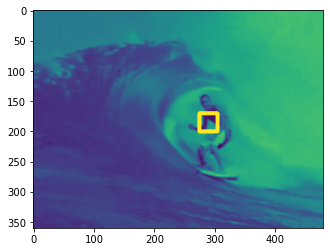

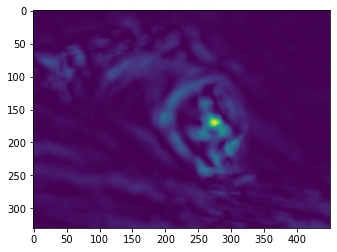

100%|██████████| 330/330 [00:10<00:00, 31.57it/s]


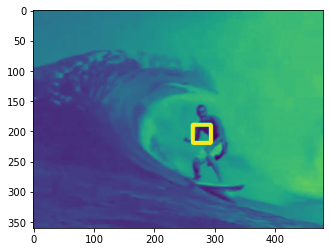

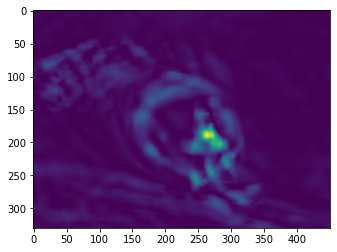

100%|██████████| 330/330 [00:10<00:00, 30.83it/s]


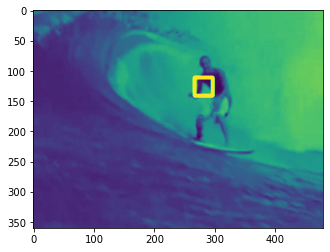

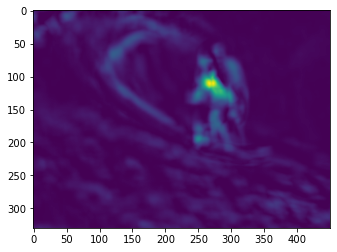

100%|██████████| 330/330 [00:10<00:00, 31.59it/s]


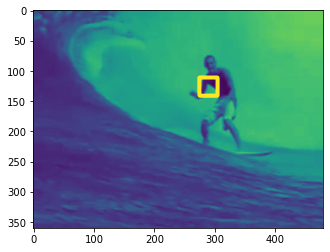

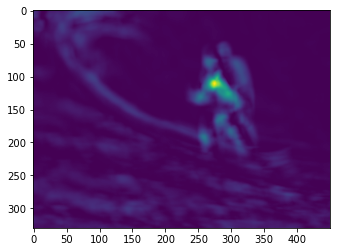

100%|██████████| 330/330 [00:11<00:00, 29.08it/s]


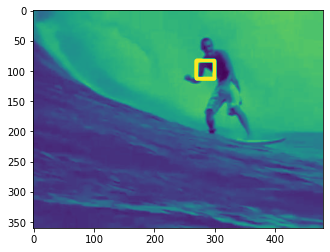

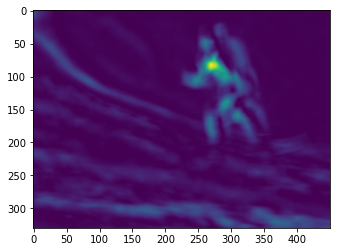

100%|██████████| 330/330 [00:11<00:00, 29.16it/s]


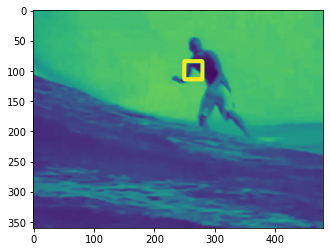

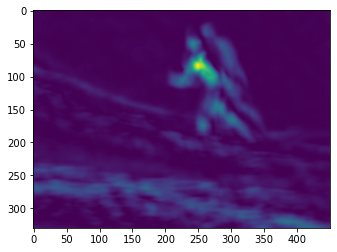

 36%|███▌      | 119/330 [00:04<00:07, 27.92it/s]


KeyboardInterrupt: 

In [10]:
main()